[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /private/var/folders/l0/hxkbr6jx32d1b49pzb9fvsz00000gn/T/pip-req-build-nw5n1l3q
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /private/var/folders/l0/hxkbr6jx32d1b49pzb9fvsz00000gn/T/pip-req-build-nw5n1l3q
  Created wheel for covid19-inference: filename=covid19_inference-0.1.6-py3-none-any.whl size=69320 sha256=504032a3224cbf6775ab6b9007145dcbcf98df79acfefbeaf9a90093a76c9930
  Stored in directory: /private/var/folders/l0/hxkbr6jx32d1b49pzb9fvsz00000gn/T/pip-ephem-wheel-cache-pfu7d1s0/wheels/49/b1/39/e7c95d0fd9fc85ca2618197f9099261dc2ec4099c681f9a8a1
Successfully built covid19-inference



<h1>Example for one region (bundesland)</h1>

  The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [2]:
import datetime
import time as time_module
import sys
import os 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

In [4]:
# Now to the fun stuff, we import our module!
try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

In [5]:
# ## Data retrieval
# The next thing we want to do is load a dataset from somewhere.
# There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
# In this example we will use the RKI dataset.

In [6]:
rki = cov19.data_retrieval.RKI() #It is important to download the dataset!
rki.download_all_available_data(); #One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval.retrieval] Successfully loaded data from local


In [7]:
# We can now access this downloaded data by the attribute
# ```
# rki.data
# ```
# but normally one would use the build in filter methods,
# these can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).
# 
# Next we retrieve the filtered data from our source in this example we will get all new cases and the total (cumulative) cases for the bundesland "Sachsen".
bd = datetime.datetime(2020,3,10) # For the date filter
ed = datetime.datetime.now()

In [8]:
total_cases_obs = rki.get_total(value="confirmed",bundesland="Sachsen",data_begin=bd,data_end=ed)
new_cases_obs = rki.get_new(value="confirmed",bundesland="Sachsen",data_begin=bd,data_end=ed)

In [9]:
# ## Create the model</h2>
# First we need to set the priors for the change points and other configs.
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

In [10]:
# We set the prior changepoints here
prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

In [11]:
change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

In [12]:
# Next, we create the model! There are default values for most of the function arguments,
# but we will try to explicitly set all kwargs for the sake of this example.
params_model = dict(new_cases_obs = new_cases_obs[:],
                    data_begin = bd,
                    fcast_len = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 
pr_median_delay = 10

In [13]:
# The model is specified in a context. Each function in this context has access to the model parameters set
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0   = 0.4,
        pr_sigma_lambda_0    = 0.5,
        change_points_list   = change_points, # The change point priors we constructed earlier
        name_lambda_t        = "lambda_t" #Name for the variable in the trace (see later)
    )
    
    # set prior distribution for the recovery rate
    mu = pm.Lognormal(
        name  = "mu",
        mu    = np.log(1/8),
        sigma = 0.2
    )
    
    
    # This builds a decorrelated prior for I_begin for faster inference. 
    # It is not necessary to use it, one can simply remove it and use the default argument 
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log           = lambda_t_log,
        mu                     = mu,
        pr_median_delay        = pr_median_delay,
        name_I_begin           = "I_begin",
        name_I_begin_ratio_log = "I_begin_ratio_log",
        pr_sigma_I_begin       = 2,
        n_data_points_used     = 5
    )
    
    # Use lambda_t_log and mu to run the SIR model
    new_I_t = cov19.model.SIR(
        lambda_t_log = lambda_t_log,
        mu           = mu,
        name_new_I_t = "new_I_t",
        name_I_t     = "I_t",
        name_I_begin = "I_begin",
        pr_I_begin   = prior_I
    )
    
    # Delay the cases by a lognormal reporting delay
    new_cases_inferred_raw = cov19.model.delay_cases(
        cases              = new_I_t,
        name_delay         = "delay",
        name_delayed_cases = "delayed_cases",
        name_width         = "delay-width",
        pr_mean_of_median  = pr_median_delay,
        pr_sigma_of_median = 0.2,
        pr_median_of_width = 0.3
    )
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    new_cases_inferred = cov19.model.week_modulation(
        new_cases_raw           = new_cases_inferred_raw,
        name_weekend_factor     = "weekend_factor",
        name_offset_modulation  = "offset_modulation",
        week_modulation_type    = "abs_sine",
        pr_mean_weekend_factor  = 0.3,
        pr_sigma_weekend_factor = 0.5,
        week_end_days           = (6, 7)
    )
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases_inferred)

TypeError: lambda_t_with_sigmoids() got an unexpected keyword argument 'name_lambda_t'

In [14]:
# ## MCMC sampling

In [15]:
trace = pm.sample(model=this_model, tune=500, draws=1000, init='advi+adapt_diag')

ValueError: The model does not contain any free variables.

In [16]:
# ## Plotting
# Plotting tools are rudimentary right now. But one can always write custom plotting function 
# by accessing the samples stored in the trace.

Possible varnames are :
[]


NameError: name 'trace' is not defined

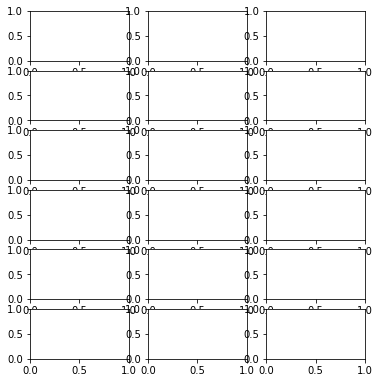

In [17]:
# ### Distributions
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = cov19.plotting.get_all_free_RVs_names(this_model)
print("Possible varnames are :")
print(varnames)
 
for i, key in enumerate(
  # left column
  ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
  cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

In [18]:
for i, key in enumerate(
  # mid column
  [
    "offset_modulation",
    "sigma_obs",
    "I_begin",
    # beware, these guys were the begin of the transient in the paper,
    # now they are the center points (shifted by transient_len_i)
    "transient_day_1",
    "transient_day_2",
    "transient_day_3",
  ]
):
  cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

NameError: name 'trace' is not defined

In [19]:
for i, key in enumerate(
  # right column
  ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
  cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])
    
fig.tight_layout()

NameError: name 'trace' is not defined

In [20]:
# ### Timeseries
# timeseries overview, for now needs an offset variable to get cumulative cases
fig, axes = cov19.plot.timeseries_overview(model, trace, offset=total_cases[0])

NameError: name 'model' is not defined